In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools

import scipy.stats as spstats
# fourier transform
from scipy.fft import fft, ifft

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg
# from statsmodels.tsa.ar_model import ar_select_order

import os
print(os.listdir("."))


import re
res_digit = r'[0-9]'


['EEG DL.ipynb', 'Untitled.ipynb', 'feature_development.ipynb', 'data_and_processing_description.ipynb', 'featured_eeg_prediction.ipynb', 'gait_data_exploration.ipynb', '.ipynb_checkpoints', 'loading_e4_data.ipynb', 'featured_E4_prediction.ipynb', 'data_investigation_scratch.ipynb', 'Debugging end-to-end.ipynb', 'binxia_cosine_similarity_and_issues.ipynb']


In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")



thisdir = /home/luke/git/external/predicament/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/predicament/notebooks', '/home/luke/git/external/predicament', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
df = pd.read_csv("../data/other_datasets/uci_multivariate_gait_data/gait.csv")
print(f"df.shape = {df.shape}")
df.head()

df.shape = (181800, 7)


,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399


In [4]:
subjects = df['subject'].unique()
conditions = df['condition'].unique()
legs = df['leg'].unique()
joints = df['joint'].unique()
replications = df['replication'].unique()
times = df['time'].unique()
print(f"subjects = {subjects}")
print(f"conditions = {conditions}")
print(f"replications = {replications}")
print(f"joints = {joints}")
print(f"legs = {legs}")
print(f"joints = {joints}")
print(f"times = {times}")



subjects = [ 1  2  3  4  5  6  7  8  9 10]
conditions = [1 2 3]
replications = [ 1  2  3  4  5  6  7  8  9 10]
joints = [1 2 3]
legs = [1 2]
joints = [1 2 3]
times = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]


In [5]:
for subject in subjects:
    subject_df = df[df['subject'] == subject]
    print(f"subject {subject}: has {subject_df.shape[0]} datapoints with {subject_df['time'].max()} time-points")
    
    
    

subject 1: has 18180 datapoints with 100 time-points
subject 2: has 18180 datapoints with 100 time-points
subject 3: has 18180 datapoints with 100 time-points
subject 4: has 18180 datapoints with 100 time-points
subject 5: has 18180 datapoints with 100 time-points
subject 6: has 18180 datapoints with 100 time-points
subject 7: has 18180 datapoints with 100 time-points
subject 8: has 18180 datapoints with 100 time-points
subject 9: has 18180 datapoints with 100 time-points
subject 10: has 18180 datapoints with 100 time-points


In [5]:
s1_c1_r1_df = df[(df['subject'] == 1) &(df['condition'] == 1) &(df['replication'] == 1)]
T = times.size
n_channels = len(legs)*len(joints)

s1_c1_r1_df.head()

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399


In [6]:
X111 = np.zeros((n_channels, T))
for c,(leg, joint) in enumerate(itertools.product(legs,joints)):
    X111[c,:] = s1_c1_r1_df[(s1_c1_r1_df['leg']==leg)&(s1_c1_r1_df['joint']==joint)]['angle'].to_numpy()


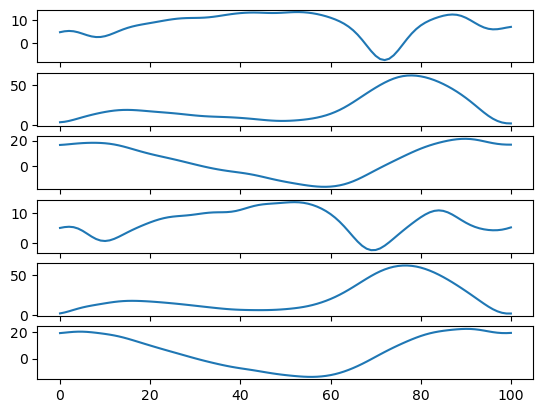

In [7]:
# the data looks like it has already been smoothed/filtered so
# we will not be applying any filtering to this dataset
fig, axs = plt.subplots(n_channels,1)
for c,(leg, joint) in enumerate(itertools.product(legs,joints)):
    axs[c].plot(times, X111[c,:])


## Aggregate functions

Taken from:
Public Domain Dataset for Human Activity Recognition Using Smartphones, (Anguita et al., 2013)

| Function	|	Description |
|  :---:	|	:---:  |
| mean	|	Mean value |
| std	|	Standard deviation |
| mad	|	Median absolute value |
| max	|	Largest values in array |
| min	|	Smallest value in array |
| sma	|	Signal magnitude area |
| energy	|	Average sum of the squares |
| iqr	|	Interquartile range |
| entropy	|	Signal Entropy |
| arCoeff	|	Autorregresion coefficients |
| correlation	|	Correlation coefficient |
| maxFreqInd	|	Largest frequency component |
| meanFreq	|	Frequency signal weighted average |
| skewness	|	Frequency signal Skewness |
| kurtosis	|	Frequency signal Kurtosis |
| energyBand	|	Energy of a frequency interval |
| angle	|	Angle between two vectors |


## Things to explore

[Hurst exponent](https://www.mdpi.com/1099-4300/23/12/1672), [Lyapunov exponent spectrum](), [Lempev-Ziv Complexity]()


In [9]:
from predicament.data.features import convert_timeseries_to_features
feature_set = set(
    ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
     'Energy', 'IQR', 'Entropy',
    'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
    'FreqKurtosis', 'EnergyBands'])
features111, feature_names = convert_timeseries_to_features(
        X111, feature_set,
        entropy_tol=0.05*(np.mean(np.std(X111,axis=1))))
print(f"features111.shape = {features111.shape}")
print(f"feature_names.shape = {len(feature_names)}")
print(f"feature_names = {feature_names}")


features111.shape = (111,)
feature_names.shape = 111
feature_names = ['Mean0', 'Mean1', 'Mean2', 'Mean3', 'Mean4', 'Mean5', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4', 'SD5', 'MAD0', 'MAD1', 'MAD2', 'MAD3', 'MAD4', 'MAD5', 'Max0', 'Max1', 'Max2', 'Max3', 'Max4', 'Max5', 'Min0', 'Min1', 'Min2', 'Min3', 'Min4', 'Min5', 'Energy0', 'Energy1', 'Energy2', 'Energy3', 'Energy4', 'Energy5', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'IQR4', 'IQR5', 'Entropy0', 'Entropy1', 'Entropy2', 'Entropy3', 'Entropy4', 'Entropy5', 'arCoeff0', 'arCoeff1', 'arCoeff2', 'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14', 'arCoeff15', 'arCoeff16', 'arCoeff17', 'arCoeff18', 'arCoeff19', 'arCoeff20', 'arCoeff21', 'arCoeff22', 'arCoeff23', 'Correlation0', 'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4', 'Correlation5', 'Correlation6', 'Correlation7', 'Correlation8', 'Correlation9', 'Correlation10', 'Correlation11', 'Correla

In [27]:
# adapted from:
# https://stackoverflow.com/questions/46296891/entropy-estimator-based-on-the-lempel-ziv-algorithm-using-python
import math
def contains(small, big):
    try:
        big.tobytes().index(small.tobytes())//big.itemsize
        return True
    except ValueError:
        return False

def lempel_ziv_entropy(l):
    """
    input
    -----
    l - a 1d numpy timeseries array 
    """
    n = len(l)
    sum_gamma = 0

    for i in range(1, n):
        sequence = l[:i]

        for j in range(i+1, n+1):
            s = l[i:j]
            if contains(s, sequence) != True:
                sum_gamma += len(s)
                break

    ae = 1 / (sum_gamma / n) * math.log(n)
    return ae




In [30]:
for c in range(X111.shape[0]):
    ent_raw = lempel_ziv_entropy(X111[c,:])
    print(f"ent_raw = {ent_raw}")
    ent_str = lempel_ziv_entropy(X111[c,:].astype(str))
    print(f"ent_str = {ent_str}")
    

ent_raw = 4.661271722009673
ent_str = 4.661271722009673
ent_raw = 4.661271722009673
ent_str = 4.661271722009673
ent_raw = 4.661271722009673
ent_str = 4.661271722009673
ent_raw = 4.661271722009673
ent_str = 4.661271722009673
ent_raw = 4.661271722009673
ent_str = 4.661271722009673
ent_raw = 4.661271722009673
ent_str = 4.661271722009673


In [34]:
def quantize_timeseries(x, amp_max, amp_min, bits_per=16):
    bins = np.linspace(amp_min, amp_max, 2**bits_per+1)
    seq = X111[0,:]
    if bits_per == 16:
        quantized = np.empty(seq.size, dtype=np.int16)
    elif bits_per == 32:
        quantized = np.empty(seq.size, dtype=np.int32)
    else:
        raise ValueError(f'Invalid bits per {bits_per}')
    for b in range(bits_per):
        quantized[(seq >= bins[b]) & (seq < bins[b+1]) ]
    return quantized



In [36]:
for c in range(X111.shape[0]):
    amp_max = X111[c,:].max()+0.1
    amp_min = X111[c,:].min()-0.1
    x = X111[c,:]
    quantized =  quantize_timeseries(x)
    lze = lempel_ziv_entropy(quantized)
    print(f"lze = {lze}")

lze = 3.6416185328200563
lze = 2.319040657716255
lze = 3.6416185328200563
lze = 2.319040657716255
lze = 3.6416185328200563
lze = 2.319040657716255


In [22]:
for i in range(3):
    seq = X111[0,0:i]
    print(f"i={i}, seq = {seq}")
    print(f"seq.tobytes() = {seq.tobytes()}")
    print(f"seq.astype(str) = {seq.astype(str)}")
    print(f"seq.astype(str).tobytes() = {seq.astype(str).tobytes()}")
seq = np.array([4.68288097])
print(f"seq = {seq}")
print(f"seq.tobytes() = {seq.tobytes()}")
seq = np.array([4], dtype=int)
print(f"seq = {seq}")
print(f"seq.tobytes() = {seq.tobytes()}")
seq = np.array([5], dtype=int)
print(f"seq = {seq}")
print(f"seq.tobytes() = {seq.tobytes()}")


i=0, seq = []
seq.tobytes() = b''
seq.astype(str) = []
seq.astype(str).tobytes() = b''
i=1, seq = [4.68288098]
seq.tobytes() = b'O\xed\x96&E\xbb\x12@'
seq.astype(str) = ['4.68288097664056']
seq.astype(str).tobytes() = b'4\x00\x00\x00.\x00\x00\x006\x00\x00\x008\x00\x00\x002\x00\x00\x008\x00\x00\x008\x00\x00\x000\x00\x00\x009\x00\x00\x007\x00\x00\x006\x00\x00\x006\x00\x00\x004\x00\x00\x000\x00\x00\x005\x00\x00\x006\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
i=2, seq = [4.68288098 5.0731274 ]
seq.tobytes() = b'O\xed\x96&E\xbb\x12@yn\x01\xe9\xe1J\x14@'
seq.astype(str) = ['4.68288097664056' '5.07312740393865']
seq.astype(str).tobytes() = b'4\x00\x00\x00.\x00\x00\x006\x00\x00\x008\x00\x00\x002\x00\x00\x008\x00\x00\x008\x00\x00\x000\x00\x00\x009\x00\x00\x007\x00\x00\x006

## Creating design matrix of manual features

In [10]:
def get_timeseries(df, subject, condition, replication, legs=None, joints=None):
    if legs is None:
        legs = df['leg'].unique()
    if joints is None:
        joints = df['joint'].unique()
    X = np.zeros((n_channels, T))
    scr_df = df[(df['subject'] == subject) &(df['condition'] == condition) &(df['replication'] == replication)]
    for c,(leg, joint) in enumerate(itertools.product(legs,joints)):
        X[c,:] = scr_df[(scr_df['leg']==leg)&(scr_df['joint']==joint)]['angle'].to_numpy()
    return X

In [38]:
feature_set = set(
    ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
     'Energy', 'IQR', 'Entropy',
    'arCoeff', 'Correlation', 'Hurst',
    'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
    'FreqKurtosis', 'EnergyBands'
    ])
entropy_tol = 1
output_lol = []
scr_cols = ['subject','condition','replication']
for subject, condition, replication, in np.unique(df[scr_cols].values, axis=0):
    # for each unique subject, condition and replication
    X = get_timeseries(df, subject, condition, replication)
    features, feature_names = convert_timeseries_to_features(
        X, feature_set, entropy_tol=entropy_tol, hurst_kind='random_walk')
    output_lol.append(
        np.concatenate(
            ((subject, condition, replication), features)))
all_columns = scr_cols + feature_names
output_df = pd.DataFrame(output_lol,columns=all_columns)
output_df

,subject,condition,replication,Mean0,Mean1,Mean2,Mean3,Mean4,Mean5,SD0,...,Max2,Max3,Max4,Max5,Min0,Min1,Min2,Min3,Min4,Min5
0,1.0,1.0,1.0,7.850984,21.860145,4.597241,7.061943,22.231482,5.737394,5.111745,...,21.401424,13.584862,62.445295,22.082553,-7.352817,2.200452,-15.965032,-2.373065,2.091054,-13.538889
1,1.0,1.0,2.0,7.003371,22.046200,2.934972,7.019926,24.393793,7.028008,5.639301,...,20.484142,11.865704,66.191037,24.109056,-10.021197,2.294759,-17.492003,-3.122549,2.277918,-13.201554
2,1.0,1.0,3.0,6.907690,21.322701,4.043684,6.819900,23.229125,5.152094,5.078220,...,21.261535,13.877307,65.300057,23.434250,-7.873404,-0.127215,-16.231325,-5.895261,3.332682,-16.203803
3,1.0,1.0,4.0,6.380351,21.382904,4.930818,6.854509,23.377511,6.430136,4.695905,...,22.073713,13.019480,65.802016,24.997317,-7.545224,-0.291447,-16.467403,-5.086294,3.106687,-14.589406
4,1.0,1.0,5.0,6.618724,20.029062,4.116368,6.731278,21.839641,5.738954,4.682028,...,20.981106,12.816035,64.093660,22.574356,-6.208922,-0.148363,-16.289473,-4.749686,1.082161,-15.404187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,10.0,3.0,6.0,4.898748,16.617524,14.213398,-4.118666,15.443605,12.678103,6.267048,...,30.151928,-1.094239,48.463338,30.487791,-12.876527,-3.340662,-9.079544,-8.000937,-3.719633,-12.052739
296,10.0,3.0,7.0,4.279994,17.544801,12.398080,-4.005039,15.673333,12.378648,6.270504,...,29.139327,-1.286535,50.472537,30.956483,-13.976071,-3.460174,-10.234694,-7.278861,-3.047156,-12.752323
297,10.0,3.0,8.0,4.972162,16.358994,13.095796,-4.031724,15.479382,11.532245,5.934044,...,27.898749,-0.785391,53.759707,32.190169,-10.484956,-3.340469,-9.791279,-9.750867,-3.224687,-13.388878
298,10.0,3.0,9.0,5.038511,18.387504,13.683937,-3.851888,15.695331,11.396588,5.985309,...,28.833213,-0.964694,51.452044,30.351050,-11.294362,-1.467940,-8.134771,-7.918919,-3.862057,-12.405920


In [14]:
list(output_df.dtypes)

[dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('floa

columns_to_use = ['Mean0', 'Mean1', 'Mean2', 'Mean3', 'Mean4', 'Mean5', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4', 'SD5']
designmtx.shape = (300, 12)
condition_data.shape = (300,)
subject_data.shape = (300,)
design2d.shape = (300, 2)


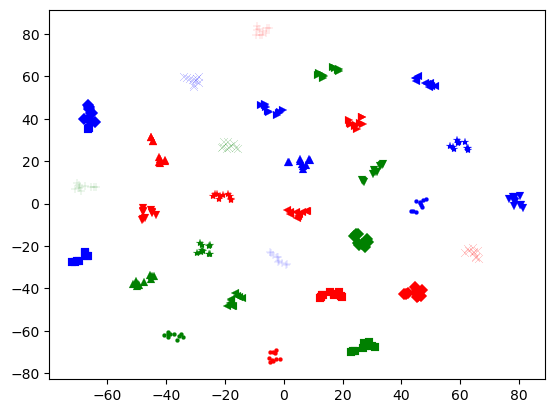

In [50]:
from sklearn.manifold import TSNE

features_to_use = set(
    ['Mean', 'SD', #'MAD', 'Max', 'Min',# 'SMA',
#      'Energy', 'IQR', 'Entropy',
#     'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
#     'FreqKurtosis', 'EnergyBands'
    ])
columns_to_use = [ col for col in output_df.columns if re.sub(res_digit, '', col) in features_to_use ]
print(f"columns_to_use = {columns_to_use}")

designmtx = output_df[columns_to_use].values 
condition_data = output_df['condition'].values.astype(int)
subject_data = output_df['subject'].values.astype(int)
print(f"designmtx.shape = {designmtx.shape}")
print(f"condition_data.shape = {condition_data.shape}")
print(f"subject_data.shape = {subject_data.shape}")

design2d = TSNE(n_components=2, init='random', perplexity=3).fit_transform(designmtx)
print(f"design2d.shape = {design2d.shape}")
import matplotlib.pyplot as plt
subjects = np.unique(subject_data)
conditions = np.unique(condition_data)
import matplotlib
markers = ['v', '^', '<', '>', 's', '*', '+' , 'x', 'D', '.']
colours = ['b','g','r','y','k']
for s,subject in enumerate(subjects):
    marker = s
    for c, condition in enumerate(conditions):
        _filter = (condition_data==condition) &(subject_data==subject)
        #print(f"condition = {condition}")
        #print(f"np.sum(_filter) = {np.sum(_filter)}")
        plt.plot(design2d[_filter,0], design2d[_filter,1], ls='None', marker=markers[s], color=colours[c], markeredgewidth=0.1)
        
# for s,subject in enumerate(subjects):
#     marker = s
#     for c, condition in enumerate(conditions):
#         _filter = designmtx[:,1]==condition
#         #print(f"condition = {condition}")
#         #print(f"np.sum(_filter) = {np.sum(_filter)}")
#         plt.plot(design2d[_filter,0], design2d[_filter,1], ls='None', marker=markers[s], color=colours[c], markeredgewidth=0.1)

In [30]:
output_df.to_csv("../data/other_datasets/uci_multivariate_gait_data/gait_features.csv")

## Classification

In [35]:
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold

models = {
    "Random Forest": RandomForestClassifier(
        min_samples_leaf=5, random_state=0
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        max_leaf_nodes=15, random_state=0
    ),
}
param_grids = {
    "Random Forest": {"n_estimators": [10, 20, 50, 100]},
    "Gradient Boosting": {"n_estimators": [10, 20, 50, 100]},
}
cv = KFold(n_splits=5, shuffle=True, random_state=0)

In [47]:

# Match all digits in the string and replace them with an empty string
# new_string = re.sub(pattern, '', string1)

features_to_use = set(
    ['Mean', 'SD', #'MAD', 'Max', 'Min',# 'SMA',
#      'Energy', 'IQR', 'Entropy',
#     'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
#     'FreqKurtosis', 'EnergyBands'
    ])
columns_to_use = [ col for col in output_df.columns if re.sub(res_digit, '', col) in features_to_use ]
print(f"columns_to_use = {columns_to_use}")

designmtx = output_df[columns_to_use].values 
condition_data = output_df['condition'].values.astype(int)
subject_data = output_df['subject'].values.astype(int)


results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
    ).fit(designmtx, condition_data)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

columns_to_use = ['Mean0', 'Mean1', 'Mean2', 'Mean3', 'Mean4', 'Mean5', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4', 'SD5']


In [48]:
results

[{'model': 'Random Forest',
  'cv_results':    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
  0       0.013796      0.005358         0.001285        0.000435   
  1       0.021243      0.001511         0.002158        0.000964   
  2       0.050508      0.001239         0.003429        0.000058   
  3       0.103350      0.007416         0.006417        0.000149   
  
    param_n_estimators                 params  split0_test_score  \
  0                 10   {'n_estimators': 10}                1.0   
  1                 20   {'n_estimators': 20}                1.0   
  2                 50   {'n_estimators': 50}                1.0   
  3                100  {'n_estimators': 100}                1.0   
  
     split1_test_score  split2_test_score  split3_test_score  ...  \
  0                1.0                1.0                1.0  ...   
  1                1.0                1.0                1.0  ...   
  2                1.0                1.0                1.0

In [49]:
results[0]['cv_results']['mean_test_score']

0    1.0
1    1.0
2    1.0
3    1.0
Name: mean_test_score, dtype: float64